In [1]:

import functools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
import lightkurve as lk
import kplr
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('comet_project')
import analysis_tools_cython as tools

%matplotlib widget 

In [2]:
kic = kplr.API()
kic.data_root = '../lc'


In [3]:
star = 3542116
#star = kic.star(3542116)
# lcs = star.get_light_curves()


# i = np.where(tools.d2q(1176) == np.array([l.sci_data_quarter for l in lcs]))[0][0]
# print(i, lcs[i].filename)
# _ = lcs[i].open() # force download

In [4]:
hdulist = fits.open('Kepler/kplr003542116-2012088054726_llc.fits')
scidata = hdulist[1].data
table = Table(scidata)['TIME','SAP_FLUX','PDCSAP_FLUX','SAP_QUALITY']

fig, ax = plt.subplots(2, figsize=(9.5,5), sharex=True)
ax[0].plot(table['TIME'], table['SAP_FLUX']/np.nanmean(table['SAP_FLUX']), '.')
ax[0].plot(table['TIME'], table['PDCSAP_FLUX']/np.nanmean(table['PDCSAP_FLUX']), '.')

q_ind = tools.get_quality_indices(table['SAP_QUALITY'])
for j,ind in enumerate(q_ind):
    if len(ind) > 0:
        ax[1].plot(table['TIME'][ind], np.zeros(len(ind))+j+1, '.')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### plot of before/after lomb-scargle filtering of light curve, including test statistic

In [5]:
def get_lc(file, drop_bad_points=True, keep_interpolated=True, ok_flags=[5]):
    '''get light curve'''
    table = tools.import_lightcurve(file, drop_bad_points=drop_bad_points, ok_flags=ok_flags)
    t,flux,quality,real = tools.clean_data(table)
    if not keep_interpolated:
        t = t[np.array(real,dtype=bool)]
        flux = flux[np.array(real,dtype=bool)]
        quality = quality[np.array(real,dtype=bool)]
        real = real[np.array(real,dtype=bool)]
    timestep = tools.calculate_timestep(table)
    flux = tools.normalise_flux(flux)
    flux_ls = np.copy(flux)
    tools.lombscargle_filter(t,flux_ls,real,0.05)
    flux_ls = flux_ls * real
    return t, timestep, flux, flux_ls, quality, real

t, timestep, flux, flux_ls, quality, real = get_lc('Kepler/kplr003542116-2012088054726_llc.fits', keep_interpolated=False)

In [6]:
def get_stat(flux_ls):
    '''get transit statistic'''
    T = tools.test_statistic_array(flux_ls,60)
    data = tools.nonzero(T)
    m,n = np.unravel_index(T.argmin(),T.shape)
    return T, m, n

T, m, n = get_stat(flux_ls)

minT = T[m,n]
minT_time = t[n]
minT_duration = m*timestep

print(minT)
print(minT_duration)
print(n)

-37.14221954345703
0.4699754535104148
3275


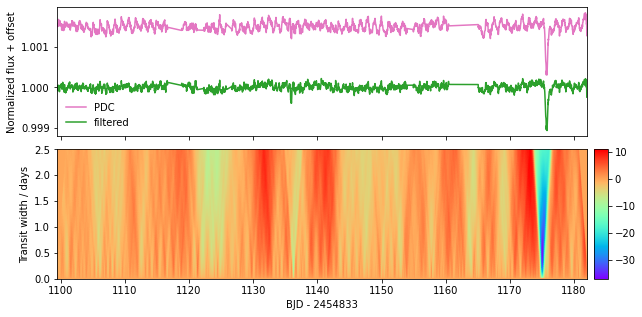

In [7]:
# need to set keep_interpolated to True for T to line up with light curve
fig, ax = plt.subplots(2, figsize=(9.5,5), sharex=True)

ax[0].plot(t, flux+1.0015, '-', color='C6', label='PDC')
ax[0].plot(t, flux_ls+1, '-', color='C2', label='filtered')
ax[0].set_xlim(np.min(t), np.max(t))
ax[0].legend(loc=3, frameon=False)
# ax[0].set_ylim(0.9985, 1.0021)

im = ax[1].imshow(T, origin='bottom', extent=ax[0].get_xlim()+(0,2.5), aspect='auto',
                  cmap='rainbow')
ax[1].set_ylim(0,2.5)

ax[0].set_ylabel('Normalized flux + offset')
ax[1].set_xlabel('BJD - 2454833')
ax[1].set_ylabel('Transit width / days')

fig.subplots_adjust(hspace=0.1)

cax = fig.add_axes([.91, ax[1].get_position().min[1], 0.02, ax[1].get_position().height])

fig.colorbar(im, cax=cax)

pos = ax[0].get_position()
pos2 = ax[1].get_position()
ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])

fig.savefig('figs/periodics.pdf')

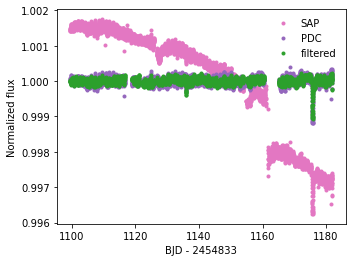

In [8]:
# a nice version
fig, ax = plt.subplots(figsize=(5,3.75))
ax.plot(table['TIME'], table['SAP_FLUX']/np.nanmean(table['SAP_FLUX']), '.', color='C6', label='SAP')
ax.plot(table['TIME'], table['PDCSAP_FLUX']/np.nanmean(table['PDCSAP_FLUX']), '.', color='C4', label='PDC')
ax.plot(t, flux_ls+1, '.', color='C2', label='filtered')

ax.legend(frameon=False)
# ax.set_xlim(375,392)
# ax.set_ylim(0.997,1.004)
ax.set_ylabel('Normalized flux')
ax.set_xlabel('BJD - 2454833')

fig.tight_layout()
fig.savefig('figs/lc-before-after.pdf')

[5.90177967e+04 5.83650033e-02 2.68622130e+00]
4.072169834352778


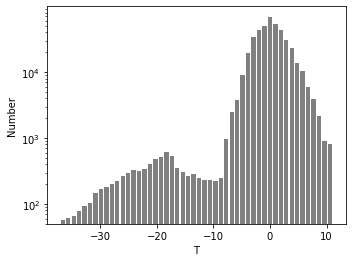

In [9]:
fig, ax = plt.subplots(figsize=(5,3.75))

bottom = 50
hist, bins = np.histogram(T, bins=50, normed=False)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
ax.bar(center, hist-bottom, align='center', width=width, bottom=bottom,
       color='grey')#, edgecolor=np.repeat('grey', len(bins)))
ylim = ax.get_ylim()

p = tools.single_gaussian_curve_fit(center, hist)
print(p)
print(np.std(T))
# ax.plot(center, tools.gauss(center, p[0], p[1], np.std(T)), color='black', alpha=0.5, linewidth=2)

# ax.set_ylim(ylim[0],ylim[1]*1.2)
ax.set_yscale('log')
ax.set_xlabel('T')
ax.set_ylabel('Number')

fig.tight_layout()
fig.savefig('figs/T_hist.pdf')

### fits to a dip

In [10]:
def curve_fit(m, n, t, flux_ls, real, verb=False, cutout_half_width=5, n_m_bg_start=3, n_m_bg_end=1):
    '''get fit results'''
    asym, width1, width2 = tools.calc_shape(m,n,t,flux_ls) # uses updated defaults
    if asym == -3 or asym == -2:
        return np.repeat(None,5)
    w = cutout_half_width
    t2 = t[n-w*m:n+w*m]
    if (t2[-1]-t2[0]) / np.median(np.diff(t2)) / len(t2) > 1.5:
        print('gap in wide')
    t3 = t[int(n-m/2.):int(n+m/2.)]
    if (t3[-1]-t3[0]) / np.median(np.diff(t3)) / m > 1.5:
        print('gap near dip')
    x2 = flux_ls[n-w*m:n+w*m]
    #background_level = (sum(x2[:m]) + sum(x2[(2*w-1)*m:]))/(2*m)
    bg_l1 = np.mean(x2[:n_m_bg_start*m]) 
    bg_t1 = np.mean(t2[:n_m_bg_start*m])
    bg_l2 = np.mean(x2[(2*w-n_m_bg_end)*m:])
    bg_t2 = np.mean(t2[(2*w-n_m_bg_end)*m:])
    grad = (bg_l2-bg_l1)/(bg_t2-bg_t1) # gradient of (if any) change in flux trend before/after transit.
    background_level = bg_l1 + grad * (t2 - bg_t1)
    x2 -= background_level

    paramsgauss = tools.single_gaussian_curve_fit(t2,-x2)
    y2 = -tools.gauss(t2,*paramsgauss)
    paramscomet = tools.comet_curve_fit(t2,-x2)
    w2 = -tools.comet_curve(t2,*paramscomet)
    scores = [tools.score_fit(x2,fit) for fit in [y2, w2]]
    if verb:
        print("Asym score:",round(scores[0]/scores[1],4))
        print('Asym score:',asym)
        print(tools.classify(m, n, real, asym))
        
    return t2, x2, y2, w2, asym

t2, x2, y2, w2, asym = curve_fit(m, n, t, flux_ls, real, verb=True)

Asym score: 1.4968
Asym score: 1.4967836241325854
maybeTransit


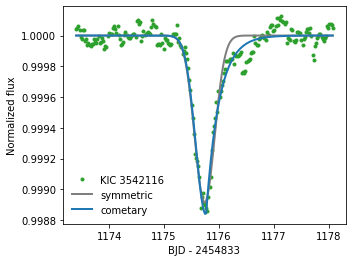

In [11]:
def show_fit(t2, x2, y2, w2, file=None, width=None, name=None, ylim=None):
    '''show fit'''
    fig, ax = plt.subplots(figsize=(5,3.75))

    ax.plot(t2, x2+1, '.', label='KIC {}'.format(name), color='C2')
#     ax.plot(t2, x2-w2+1, '.', label='KIC {}'.format(name), color='C2')
    ax.plot(t2, y2+1.0000, linewidth=2, label='symmetric', color='C7')
    ax.plot(t2, w2+1, linewidth=2, label='cometary', color='C0')
    ax.legend(frameon=False)

    ax.set_ylabel('Normalized flux')
    ax.set_xlabel('BJD - 2454833')

    if width is not None:
        mid = (t2[-1]+t2[0])/2.
        ax.set_xlim(mid-width/2,mid+width/2)
        
    if ylim is not None:
        ax.set_ylim(ylim)
    
    fig.tight_layout()
    if file:
        fig.savefig(file)
        
show_fit(t2, x2, y2, w2, name=3542116, width=None, file='figs/modelfits.pdf')

### other light curves

In [12]:
# take a closer look
def fit_one(kic_no, day, drop_bad_points=True, width=None, file=None, ylim=None):
    '''do everything'''
    star = kic.star(kic_no)
    lcs = star.get_light_curves()
    i = np.where(tools.d2q(day) == np.array([l.sci_data_quarter for l in lcs]))[0][0]
    _ = lcs[i].open() # force download
    t, timestep, flux, flux_ls, quality, real = get_lc(lcs[i].filename,
                                                       drop_bad_points=drop_bad_points,
                                                       keep_interpolated=False)
    T, m, n = get_stat(flux_ls)
#     flux_ls -= gp_detrend(m, n, t, flux_ls)
    t2, x2, y2, w2, asym = curve_fit(m, n, t, flux_ls, real, verb=True)
    if t2 is not None:
        show_fit(t2, x2, y2, w2, width=width, name=kic_no, file=file, ylim=ylim)
    else:
        print('fit failed')

In [13]:
# the ones we know about
kic_r18 = [3542116, 11084727]

# those marked as artefacts
artefacts = Table.read('artefact_list.txt', format='ascii.csv', comment='#')
kic_artefacts = list(artefacts['koi'])

In [14]:
# select a subset
data = Table.read('all_snr_gt_5_ok.txt', format='ascii') # list of s/n>5 maybeTransits satisfying width criteria

len(data)

7217

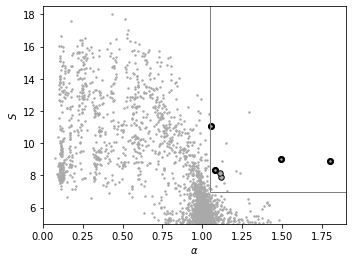

In [15]:
# candidates
fig, ax = plt.subplots(figsize=(5,3.75))

rect = matplotlib.patches.Rectangle((1.05,7),3,20, linewidth=1,edgecolor='grey',facecolor='none')
ax.add_patch(rect)
# rect = matplotlib.patches.Rectangle((1.2,5),3,20,linewidth=1,edgecolor='grey',facecolor='none')
# ax.add_patch(rect)

# ax.scatter(t['alpha'], t['snr'], c='black')
for j,f in enumerate(data['col1']):
    kic_no = int(f.split('-')[0].split('kplr')[1])
    if kic_no not in kic_artefacts and data[j]['col5'] > 1.05 and data[j]['col3'] < -7:
        ax.scatter(data[j]['col5'], -data[j]['col3'], s=30, c='darkgrey', edgecolors='black')
    if kic_no in kic_r18:
        if data[j]['col5'] > 1.05:
            ax.scatter(data[j]['col5'], -data[j]['col3'], c='black')
#             ax.text(data[j]['col5'], -data[j]['col3'], f.split('-')[0].split('kplr')[1]+','+str(data[j]['col4']))
            
ax.scatter(data['col5'], -data['col3'], s=2, c='darkgrey')

ax.set_xlim(0,1.9)
ax.set_ylim(5,18.5)
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$S$')

fig.tight_layout()
fig.savefig('figs/asym_snr.pdf')

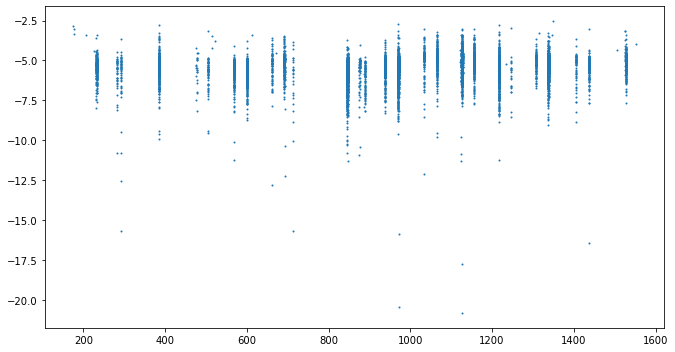

In [16]:
# check gapJustBefore tend to be at specific times
data1 = Table.read('all_snr_gt_5.txt', format='ascii') # list of s/n>5 maybeTransits satisfying width criteria
ok = data1['col10'] == 'gapJustBefore'
fig, ax = plt.subplots(figsize=(9.5,5))
ax.scatter(data1['col4'][ok], data1['col3'][ok], s=1)
# ax.scatter(t['day'], -t['snr'], c='black')
fig.tight_layout()

In [17]:
ok = (data['col5'] > 1.05) & (data['col3'] < -7)
# ok = (data['col3'] > -5.1) & (data['col3'] < -5)
print('in region:{}'.format(np.sum(ok)))
keep = []
for i,row in enumerate(data[ok]):
    print(row)
    kic_no = int(row['col1'].split('-')[0].split('kplr')[1])
    if kic_no in kic_artefacts:
        print('artefact')
    else:
        fit_one(kic_no, row['col4'], drop_bad_points=True, #width=8, ylim=(0.9982, 1.00035),
                file='figs/kic{}-{:04.0f}.pdf'.format(kic_no,row['col4']))
        keep.append(i)

in region:16
                col1                     col2         col3        col4        col5      col6       col7       col8       col9       col10    
------------------------------------ ------------ ----------- ------------ --------- ---------- ---------- ---------- ---------- ------------
kplr004054905-2010078095331_llc.fits -46.10757446 -8.87541694 395.22488737 1.1234713 0.23157341 0.57612845 1.08298994 -0.0209167 maybeTransit
artefact
                col1                     col2         col3        col4        col5       col6       col7       col8        col9       col10    
------------------------------------ ------------ ----------- ------------ ---------- ---------- ---------- ---------- ----------- ------------
kplr004055609-2010174085026_llc.fits -34.37948608 -7.35711584 488.30299149 1.08499623 0.20060077 0.58707276 0.89911825 -0.00128943 maybeTransit
artefact
                col1                     col2         col3        col4        col5       col6      col7       c

APIError: The API returned code 200 for URL: 'https://archive.stsci.edu/kepler/kic10/search.php?kic_kepler_id=3129239&max_records=1&action=Search&outputformat=JSON&coordformat=dec&verb=3' with message:
No JSON object could be decoded.
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN"
 "http://www.w3.org/TR/html4/loose.dtd">
<html lang="en">
<head>
<title>KIC10 Search</title>
<meta http-equiv="Content-Type" content="text/html; charset=utf-8">
<meta name="SKYPE_TOOLBAR" content="SKYPE_TOOLBAR_PARSER_COMPATIBLE">
<meta name="description" content="The Barbara A. Mikulski Archive for Space Telescopes (MAST)">
<meta name="keywords" content="astronomical data archive, MAST, NASA, STScI, IUE, HST, Copernicus, UIT, GSC, SDSS, EPOCH, EUVE, FUSE, ASTRO, HUT, WUPPE, HPOL, BEFS, TUES, IMAPS, ORFEUS, FIRST, ROSAT, DSS, VLAFIRST, XMMOM, GALEX, Kepler, ultraviolet/optical astronomy">
<link href="/styles/default.css" type="text/css" rel="stylesheet">
<script src="/javascript/js.js" type="text/javascript" language="JavaScript"></script>
<script src="/javascript/spc.js" type="text/javascript" language="JavaScript"></script>
<script src="/javascript/drop.js" type="text/javascript" language="JavaScript"></script>
</head>

<body vlink="#990000" link="#000066" onload="copyScl()">
<noscript><center><div class='comment'>
<br><br>Warning:<br>Javascript is required to alter 
output columns and for <br>displaying search results in 
HTML. If you see this message, <br>it
means you do not have Javascript enabled in your browser.
</div></center><br><br></noscript>

   <table bgcolor="#FFFFFF" align="center" width="760" border="0" cellspacing="0" cellpadding="0"
     summary="Table containing overall page layout including top banner, nav bars, content and footer">
   <tr>
   <td colspan="3"><table width="100%" border="0" cellspacing="0" cellpadding="0">
  <tr class="tbcolor">
    <td>
    <table width="100%" border="0" cellspacing="0" cellpadding="0">
      <tr>
        <td><img alt="spacer" src="/images/spacer.gif" width="10" height="71"></td>
        <td><a href="/index.html"><img src="/images/mastlogo_new.gif" alt="link to MAST page" width="63" height="63" border="0"></a></td>
        <td><img alt="spacer" src="/images/spacer.gif" width="5" height="71"></td>
        <td><img alt="logo image" src="/images/mast_signature.gif" width="673" height="60"></td>
        <td><img alt="spacer" src="/images/spacer.gif" width="10" height="71"></td>
        <td width="300" align="center"><span class="style1">
        <span class="style2"></span> 
        </span></td>
        <td ><img alt="" src="/images/spacer.gif" width="10" height="71"></td>
      </tr>
    </table></td>
    <td width="100%"></td>
  </tr>
  <tr class="tnborder">
  <td colspan="20" height="1"></td>
  </tr>
  <tr class="tncolor">
    <td>

   <table width="100%" border="0" cellpadding="0" cellspacing="0">
     <tr><td class="uppernav">
     <div id="uppernav">
     <ul class="tnb-top">
  <li><span class="style4"><a href="/index.html"> MAST</a></span>
</li>

<li><span class="style4"><a href="http://www.stsci.edu/portal/"> STScI</a></span>
</li>

              <li><span class="style4"><a href="/searches.html"> Tools</a></span><img class="tnb-arrow" src="/images/down.gif" alt="submenus">
                 <ul class="tnb-sub1">
                <li><span class="style41"><a href="https://exo.mast.stsci.edu/exo/ExoMast/html/exomast.html"> exo.MAST</a></span>
                <li><span class="style41"><a href="https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html"> Discovery Portal</a></span>
                <li><span class="style4"><a href="/cgi-bin/nph-aladin.pl?from=STScI"> Aladin</a></span>
                <li><span class="style4"><a href="/spec_class/"> Spectral Classifications</a></span>
                <li><span class="style4"><a href="/canvas/coplot.html"> Coplotter</a></span>
                <li><span class="style4"><a href="http://specviz.readthedocs.io/en/latest/"> SpecViz Info</a></span>
                <li><span class="style4"><a href="http://starview.stsci.edu/web/"> StarView Web</a></span>
                <li><span class="style4"><a href="/abstracts.html"> Abstracts</a></span>
                <li><span class="style4"><a href="/bibliography/index.html/"> Bibliography Search</a></span>
                <li><span class="style4"><a href="/stpr/search.php/"> HST PR Images</a></span>
                <li><span class="style4"><a href="/searches.html"> more...</a></span>
                </ul>
</li>

              <li><span class="style4"><a href="/searches.html#missions"> Mission Search</a></span><img class="tnb-arrow" src="/images/down.gif" alt="submenus">
                 <ul class="tnb-sub1">
                <li><span class="style41"><a href="https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html"> Discovery Portal</a></span>
                <li><span class="style41"><a href="/hst/search.php"> Hubble</a></span>
                <li><span class="style41"><a href="http://hla.stsci.edu/hlaview.html"> Hubble Legacy Archive</a></span>
                <li><span class="style41"><a href="/hst/spectral_legacy"> Hubble Spectral Legacy Archive</a></span>
                <li><span class="style41"><a href="/hst/hsc/"> Hubble Source Catalog</a></span>
                <li><span class="style41"><a href="/stpr/search.php"> HST Press Release Images</a></span>
                <li><span class="style41"><a href="/cgi-bin/dss_form/"> DSS</a></span>
                <li><span class="style41"><a href="/jwst/sidarchive/search.php"> JWST SID Archive</a></span>
                <li><span class="style41"><a href="/k2/epic/search.php"> K2 EPIC</a></span>
                <li><span class="style41"><a href="/k2/data_search/search.php"> K2 Data</a></span>
                <li><span class="style41"><a href="/kepler/data_search/search.php"> Kepler Data</a></span>
                <li><span class="style41"><a href="/kepler/kepler_fov/search.php"> Kepler Targets</a></span>
                <li><span class="style41"><a href="/panstarrs/search.php"> PanSTARRS</a></span>
                <li><span class="style41"><a href="/swiftuvot/search.php"> SwiftUVOT</a></span>
                <li><span class="style41"><a href="/tess/index.html#searchtools"> TESS</a></span>
                <li><span class="style41"><a href="/xmm-om/search.php"> XMM-OM</a></span>
                <li><span class="style4"><a href="/befs/search.php"> BEFS (ORFEUS)</a></span>
                <li><span class="style4"><a href="/copernicus/search.php"> Copernicus-raw</a></span>
                <li><span class="style4"><a href="/copernicus/coadd/search.php"> Copernicus-coadd</a></span>
                <li><span class="style4"><a href="/epoch/epoch_mast_directory.html"> EPOCH</a></span>
                <li><span class="style4"><a href="/euve/search.php"> EUVE</a></span>
                <li><span class="style4"><a href="/fuse/search.php"> FUSE Observations</a></span>
                <li><span class="style4"><a href="/fuse/exposure/search.php"> FUSE Exposures</a></span>
                <li><span class="style4"><a href="http://galex.stsci.edu/GalexView/"> GalexView</a></span>
                <li><span class="style4"><a href="http://galex.stsci.edu/GR6/?page=mastform"> GALEX</a></span>
                <li><span class="style4"><a href="http://gsss.stsci.edu/webservices/GSC2/WebForm.aspx"> GSC</a></span>
                <li><span class="style4"><a href="/hpol/search.php"> HPOL</a></span>
                <li><span class="style4"><a href="/hut/search.php"> HUT</a></span>
                <li><span class="style4"><a href="/imaps/search.php"> IMAPS (ORFEUS)</a></span>
                <li><span class="style4"><a href="/iue/search.php"> IUE</a></span>
                <li><span class="style4"><a href="/tues/search.php"> TUES (ORFEUS)</a></span>
                <li><span class="style4"><a href="/uit/search.php"> UIT</a></span>
                <li><span class="style4"><a href="/vlafirst/search.php"> VLA-FIRST</a></span>
                <li><span class="style4"><a href="/wuppe/search.php"> WUPPE</a></span>
                <li><span class="style4"><a href="/searches.html#missions"> more...</a></span>
                </ul>
</li>

<li><span class="style4"><a href="/google_search.html"> Search Website</a></span>
</li>

              <li><span class="style4"><a href="/followus.html"><img class="tnb-arrow" src="/images/facebook.png" alt="facebook">&nbsp;<img class="tnb-arrow" src="/images/twitter.png" alt="twitter">Follow Us</a></span><img class="tnb-arrow" src="/images/down.gif" alt="submenus">
                 <ul class="tnb-sub1">
                <li><span class="style4"><a href="http://www.facebook.com/MASTArchive/"> Facebook</a></span>
                <li><span class="style4"><a href="http://www.twitter.com/MAST_News/"> Twitter</a></span>
                </ul>
</li>

<li><span class="style4"><a href="/registration/"> Register</a></span>
</li>

<li><span class="style4"><a href="http://forum.stsci.edu/"> Forum</a></span>
</li>

</li>

       </ul></div></td>
       <td width="100" align="center"><img alt="" src="/images/spacer.gif" width="100" height="8"></td>
      </tr>
    </table>
  </td>
    <td width="100%"></td>
  </tr>
  <tr bgcolor="#000000">
    <td height="1" colspan="20"><img alt="" src="/images/spacer.gif" width="1" height="1"></td>
  </tr>
  <tr><td class="lowernav">
  <div id="lowernav">
  <ul>
       <li><span class="style4"><a  href="/kepler/"> Kepler Home</a></span>     <li><span class="style4"><a  href="http://kepler.nasa.gov/Mission/QuickGuide/"> Mission</a></span>     <li><span class="style4"><a  href="/kepler/getting_started.html"> Getting Started</a></span>     <li><span class="style4"><a  href="/kepler/data_search/search.php"> Data Search</a></span>     <li><span class="style4"><a  href="/kepler/kepler_fov/search.php"> Target Search</a></span>     <li><span class="style4"><a  href="/kepler/stellar17/search.php"> Stellar17</a></span>     <li><span class="style4"><a  href="http://mastweb.stsci.edu/kplrcasjobs/"> CasJobs</a></span>     <li><span class="style4"><a  href="/kepler/ffi/search.php"> FFI+ Search</a></span>  </ul>
  </div>
  </td>
    <td width="1" class="lowernav"></td>
  </tr>

  <tr bgcolor="#000000">
    <td height="1" colspan="20"><img alt="" src="/images/spacer.gif" width="1" height="1"></td>
  </tr>

  </table>
 </td>
</tr>

<tr><td align="center" valign="top" colspan="3" bgcolor="#FFFFFF"><div id="indt2"><br><style>
#dt {
    text-align: left;
    width: 60%;
    border: 1px solid red;
    border-radius: 15px;
    padding: 0.4em 0.4em 0.4em 0.8em;
    background-color: #feeeaa;
/*     background-size: 100% 100%; */
/*     color: #fff */
}
</style>
<div id="dt">
<h3>Service interruption 31 Aug 2021</h3>
<p>This server will be unavailable 31 Aug 2021 between 10:00AM EDT and 11:00AM EDT (14:00 - 15:00 UTC) for scheduled maintenance.
As a result of this change, the server will have a different IP address.
If you have a problem reaching it after the change, try flushing your DNS cache.
</p>
</div>

<table border="0" width="100%" cellpadding="0" cellspacing="0">
<tr>
<td align="center" width="20%"><font size="-1"><b><a target="status" href="/kepler/help/archive_status.html">Archive Status</a></b></font></td>
<td align="center" width="60%"> <h1>Kepler Input Catalog<font size="-1"><br><br>Note: Use the Kepler <a href="/kepler/kepler_fov/search.php">Target Search form</a> for locating potential targets.<br>(more <a href="/kepler/kic10/help/search_help.html">info</a>)</font><p></h1></td>
<td align="center" width="20%"><font face="helvetica,arial,sans-serif" ><b><a target="help" href="/kepler/kic10/help/search_help.html">Help</a></b></font>
<br><b><a target="status" href="/search_fields.php?mission=kic10">Field Descriptions</a></b></td>
</tr>
</table>
<br>

<form  action="/kepler/kic10/search.php" name="finput" onSubmit="javascript:preprocess()" method="post">

<table border="0" cellspacing="0" cellpadding="0" width="98%">
<tr><td>

<table border="0" width="100%" cellpadding="0" cellspacing="0">
        <tr>
          <td align="center">
                &nbsp; &nbsp; &nbsp; &nbsp;
                <b><a href="/kepler/kic10/search.php">Standard Form</a></b>
          </td>
          <td align="center">
                &nbsp; &nbsp; &nbsp; &nbsp;
                <b><a href="/kepler/kic10/search.php?form=fuf">File Upload Form</a></b>
          </td>
        </tr>
</table>
<br>
<hr noshade>


<table align="center" border="0" width="100%" cellpadding="5" cellspacing="0">
  <tr class="mscolor">
    <td align="center">
		<table cellspacing=0 cellpadding=5 border=0><tr><td class="sbcolor">
          <b><input type="submit" name="action" value="Search"></b>
		</td></tr></table>
    </td>
    <td align="center">
          <b><input type="reset" value="Reset"></b>
    </td>
    <td align="center">
          <b><input type="submit" name="action" value="Clear Form"></b>
    </td>
  </tr>
</table>
<hr noshade>

<table border="0" width="100%" cellpadding="0" cellspacing="0">
        <tr class="mscolor">
          <td align="center">
                <b><a target="help" href="/kepler/kic10/help/search_help.html#object_name">Target Name</a></b> <br>
                <input type="text" tabindex="2" alt="target" name="target" value="" >
          </td>


            <td align="center">
    <b><a target="help" href="/kepler/kic10/help/search_help.html#object_resolver">Resolver</a></b><br>
    <select name="resolver" tabindex="2">
    <option value="Resolve" selected> Resolve 
    </select>
            </td>

          <td  align="center">
                <b><a target="help" href="/kepler/kic10/help/search_help.html#radius">Radius (arcmin)</a></b> <br>
                <input type="text" tabindex="2" alt="radius" name="radius" size="3" value="0.02">
          </td>
        </tr>
</table>
<table border="0" width="100%" cellpadding="0" cellspacing="0">
        <tr class="mscolor">
			<td width="10%">&nbsp;
			</td>
			<td align="center">
                <b><a target="help" href="/kepler/kic10/help/search_help.html#coordinates">Right Ascension</a></b> <br>
                <input type="text" tabindex="2" alt="ra" name="ra" value="" >
			</td>
			<td align="center">
                <b><a target="help" href="/kepler/kic10/help/search_help.html#coordinates">Declination</a></b> <br>
                <input type="text" tabindex="2" alt="dec" name="dec" value="" >
			</td>
			<td align="center">
                <b><a target="help" href="/kepler/kic10/help/search_help.html#equinox">Equinox</a></b> <br>
                <select name="equinox">
    <option value="J2000" selected> J2000 
    <option value="1950" > B1950 
    <option value="1900" > B1900 
                </select>
			</td>
			<td width="10%">&nbsp;
			</td>
        </tr>
</table>
<hr noshade>
<table width="100%" bgcolor="#ECE4D3" border="0" cellpadding="0" cellspacing="0" align="center">
<tr>
<th>&nbsp;</th>
 <th colspan="1" align="center"><a target="help" href="/kepler/kic10/help/search_help.html#kic_kepler_id">Kepler ID</a></th>
<th>&nbsp;</th>
</tr>
<tr>
 <td>&nbsp;</td>
 <td colspan="1" align="center"><input type="text" tabindex="2" name="kic_kepler_id" size ="16" value=""></td>
 <td>&nbsp;</td>
</tr>
<tr>
 <th align="center"><a target="help" href="/kepler/kic10/help/search_help.html#kic_pmtotal">Total PM (arcsec/yr)</a></th>
 <th align="center"><a target="help" href="/kepler/kic10/help/search_help.html#kic_teff">Teff (deg K)</a></th>
 <th align="center"><a target="help" href="/kepler/kic10/help/search_help.html#kic_radius">Radius (solar=1.0)</a></th>
</tr>
<tr>
 <td align="center"><input type="text" tabindex="2" name="kic_pmtotal" size ="16" value=""></td>
 <td align="center"><input type="text" tabindex="2" name="kic_teff" size ="16" value=""></td>
 <td align="center"><input type="text" tabindex="2" name="kic_radius" size ="16" value=""></td>
</tr>

<tr>
 <th align="center"><a target="help" href="/kepler/kic10/help/search_help.html#kic_ebminusv">E(B-V)</a></th>
 <th align="center"><a target="help" href="/kepler/kic10/help/search_help.html#kic_logg">Log G (cm/s/s)</a></th>
 <th align="center"><a target="help" href="/kepler/kic10/help/search_help.html#kic_feh">Metallicity (solar=0.0)</a></th>
</tr>
<tr>
 <td align="center"><input type="text" tabindex="2" name="kic_ebminusv" size ="16" value=""></td>
 <td align="center"><input type="text" tabindex="2" name="kic_logg" size ="16" value=""></td>
 <td align="center"><input type="text" tabindex="2" name="kic_feh" size ="16" value=""></td>
</tr>

</table>
<table width="100%" bgcolor="#ECE4D3" border="0" cellpadding="0" cellspacing="0" align="center">
<tr>
<td>&nbsp;</td>
</tr>
</table>
<table width="100%" bgcolor="#ECE4D3" border="0" cellpadding="2" cellspacing="0" align="center">
<tr>
<th align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a target="help" href="/kepler/kic10/help/search_help.html#user_option">User-specified field 1</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a target="help" href="/search_fields.php?mission=kic10">Field Descriptions</a></th>
<th align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a target="help" href="/kepler/kic10/help/search_help.html#user_option">User-specified field 2</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a target="help" href="/search_fields.php?mission=kic10">Field Descriptions</a></th>
</tr>
<tr>
	<td align="center"><select tabindex="2" name="extra_column_name_1">
	<option value="kic_kepler_id">Kepler ID
<option value="kic_degree_ra">RA (J2000)
<option value="kic_dec">Dec (J2000)
<option value="kic_pmra">RA PM (arcsec/yr)
<option value="kic_pmdec">Dec PM (arcsec/yr)
<option value="kic_umag">u Mag
<option value="kic_gmag">g Mag
<option value="kic_rmag">r Mag
<option value="kic_imag">i Mag
<option value="kic_zmag">z Mag
<option value="kic_gredmag">Gred Mag
<option value="kic_d51mag">D51 Mag
<option value="kic_jmag">J Mag
<option value="kic_hmag">H Mag
<option value="kic_kmag">K Mag
<option value="kic_kepmag">Kepler Mag
<option value="kic_2mass_id">2MASS ID
<option value="kic_tmid">2MASS Designation
<option value="kic_scpid">SCP ID
<option value="kic_altid">Alt ID
<option value="kic_altsource">Alt ID Source
<option value="kic_galaxy">Star/Gal ID
<option value="kic_blend">Isolated/Blend ID
<option value="kic_variable">Var. ID
<option value="kic_teff">Teff (deg K)
<option value="kic_logg">Log G (cm/s/s)
<option value="kic_feh">Metallicity (solar=0.0)
<option value="kic_ebminusv">E(B-V)
<option value="kic_av">A_V
<option value="kic_radius">Radius (solar=1.0)
<option value="kic_cq">Kepmag Source
<option value="kic_pq">Photometry Qual
<option value="kic_aq">Astrophysics Qual
<option value="kic_catkey">Catalog key
<option value="kic_scpkey">Scp Key
<option value="kic_parallax">Parallax (arcsec)
<option value="kic_glon">Gal Lon (deg)
<option value="kic_glat">Gal Lat (deg)
<option value="kic_pmtotal">Total PM (arcsec/yr)
<option value="kic_grcolor">g-r color
<option value="kic_jkcolor">J-K color
<option value="kic_gkcolor">g-K color
<option value="kic_ra">RA hours (J2000)
	</select>&nbsp;
	<input type="text" size ="10" tabindex="2" alt="extra_column_value_1" name="extra_column_value_1" value="" >
	</td>
	<td align="center"><select tabindex="2" name="extra_column_name_2">
	<option value="kic_kepler_id">Kepler ID
<option value="kic_degree_ra">RA (J2000)
<option value="kic_dec">Dec (J2000)
<option value="kic_pmra">RA PM (arcsec/yr)
<option value="kic_pmdec">Dec PM (arcsec/yr)
<option value="kic_umag">u Mag
<option value="kic_gmag">g Mag
<option value="kic_rmag">r Mag
<option value="kic_imag">i Mag
<option value="kic_zmag">z Mag
<option value="kic_gredmag">Gred Mag
<option value="kic_d51mag">D51 Mag
<option value="kic_jmag">J Mag
<option value="kic_hmag">H Mag
<option value="kic_kmag">K Mag
<option value="kic_kepmag">Kepler Mag
<option value="kic_2mass_id">2MASS ID
<option value="kic_tmid">2MASS Designation
<option value="kic_scpid">SCP ID
<option value="kic_altid">Alt ID
<option value="kic_altsource">Alt ID Source
<option value="kic_galaxy">Star/Gal ID
<option value="kic_blend">Isolated/Blend ID
<option value="kic_variable">Var. ID
<option value="kic_teff">Teff (deg K)
<option value="kic_logg">Log G (cm/s/s)
<option value="kic_feh">Metallicity (solar=0.0)
<option value="kic_ebminusv">E(B-V)
<option value="kic_av">A_V
<option value="kic_radius">Radius (solar=1.0)
<option value="kic_cq">Kepmag Source
<option value="kic_pq">Photometry Qual
<option value="kic_aq">Astrophysics Qual
<option value="kic_catkey">Catalog key
<option value="kic_scpkey">Scp Key
<option value="kic_parallax">Parallax (arcsec)
<option value="kic_glon">Gal Lon (deg)
<option value="kic_glat">Gal Lat (deg)
<option value="kic_pmtotal">Total PM (arcsec/yr)
<option value="kic_grcolor">g-r color
<option value="kic_jkcolor">J-K color
<option value="kic_gkcolor">g-K color
<option value="kic_ra">RA hours (J2000)
	</select>&nbsp;
	<input type="text" size ="10" tabindex="2" alt="extra_column_value_2" name="extra_column_value_2" value="" >
	</td>
</tr>
</table>
<hr noshade>

<table border="0" width="100%" cellpadding="0" cellspacing="0">
  <tr class="mscolor">
    <td align="Center">
         <table border="0" width="100%" cellpadding="0" cellspacing="0">
         <tr><td width="20%">&nbsp;</td><td align="center" width="40%">
         <b><a target="help" href="/kepler/kic10/help/search_help.html#output_columns">Search Output Columns</a></b><br>
          <input type="hidden" name="selectedColumnsCsv" value="">
          <select tabindex="2" name="selectedColumnsList[]"  size="10">
          <option value="kic_kepler_id" >Kepler ID
<option value="kic_degree_ra" >RA (J2000)
<option value="kic_dec" >Dec (J2000)
<option value="kic_rmag" >r Mag
<option value="kic_jmag" >J Mag
<option value="kic_kepmag" >Kepler Mag
<option value="kic_2mass_id" >2MASS ID
<option value="kic_galaxy" >Star/Gal ID
<option value="kic_teff" >Teff (deg K)
<option value="kic_logg" >Log G (cm/s/s)
<option value="kic_feh" >Metallicity (solar=0.0)
<option value="kic_ebminusv" >E(B-V)
<option value="kic_radius" >Radius (solar=1.0)
<option value="kic_parallax" >Parallax (arcsec)
<option value="kic_pmtotal" >Total PM (arcsec/yr)
<option value="kic_grcolor" >g-r color
<option value="ang_sep" >ang_sep (')
          </select>
          </td><td align="center" width="20%">

          <input type="button" value="up" onClick="javascript:moveUp(document.finput.elements['selectedColumnsList[]'])">
&nbsp;<br><br>
          <input type="button" value="down" onClick="javascript:moveDown(document.finput.elements['selectedColumnsList[]'])">
&nbsp;<br><br>
          <input type="button" value="remove" onClick="javascript:deselectColumn(document.finput.elements['selectedColumnsList[]'])">
&nbsp;<br><br>
          <input type="button" value="reset" onClick="javascript:setScl()">

          </td>
          <td width="20%">&nbsp;</td>

          <tr><td width="10%">&nbsp;</td><td align="left" valign="middle" colspan="3">
          <br>
          <input type="button" value="add" onClick="javascript:selectColumn(document.finput.availableColumns,document.finput.elements['selectedColumnsList[]'])">
          &nbsp
          <select name="availableColumns">
          <option value="kic_kepler_id">Kepler ID
<option value="kic_degree_ra">RA (J2000)
<option value="kic_dec">Dec (J2000)
<option value="kic_pmra">RA PM (arcsec/yr)
<option value="kic_pmdec">Dec PM (arcsec/yr)
<option value="kic_umag">u Mag
<option value="kic_gmag">g Mag
<option value="kic_rmag">r Mag
<option value="kic_imag">i Mag
<option value="kic_zmag">z Mag
<option value="kic_gredmag">Gred Mag
<option value="kic_d51mag">D51 Mag
<option value="kic_jmag">J Mag
<option value="kic_hmag">H Mag
<option value="kic_kmag">K Mag
<option value="kic_kepmag">Kepler Mag
<option value="kic_2mass_id">2MASS ID
<option value="kic_tmid">2MASS Designation
<option value="kic_scpid">SCP ID
<option value="kic_altid">Alt ID
<option value="kic_altsource">Alt ID Source
<option value="kic_galaxy">Star/Gal ID
<option value="kic_blend">Isolated/Blend ID
<option value="kic_variable">Var. ID
<option value="kic_teff">Teff (deg K)
<option value="kic_logg">Log G (cm/s/s)
<option value="kic_feh">Metallicity (solar=0.0)
<option value="kic_ebminusv">E(B-V)
<option value="kic_av">A_V
<option value="kic_radius">Radius (solar=1.0)
<option value="kic_cq">Kepmag Source
<option value="kic_pq">Photometry Qual
<option value="kic_aq">Astrophysics Qual
<option value="kic_catkey">Catalog key
<option value="kic_scpkey">Scp Key
<option value="kic_parallax">Parallax (arcsec)
<option value="kic_glon">Gal Lon (deg)
<option value="kic_glat">Gal Lat (deg)
<option value="kic_pmtotal">Total PM (arcsec/yr)
<option value="kic_grcolor">g-r color
<option value="kic_jkcolor">J-K color
<option value="kic_gkcolor">g-K color
<option value="kic_ra">RA hours (J2000)
<option value="kic_fov_flag">Flag
<option value="ang_sep">ang_sep (')
          </select>
	  &nbsp;<br>
          <input type="button" value="add all" onClick="javascript:selectColumns(document.finput.availableColumns,document.finput.elements['selectedColumnsList[]'])">
	  &nbsp;
          <input type="button" value="remove all" onClick="javascript:deselectColumns(document.finput.elements['selectedColumnsList[]'])">
          </td></tr>

         <tr><td>&nbsp;</td></tr>

      
         <tr><td>&nbsp;</td></tr>
      </table>
    </td>

    <td align="center" valign="top">
    &nbsp;
	<b><a target="help" href="/kepler/kic10/help/search_help.html#sort_fields">Sort By: </a></b><br>
    <select tabindex="2" name="ordercolumn1">
<option  value="kic_kepler_id">Kepler ID
<option  value="kic_degree_ra">RA (J2000)
<option  value="kic_dec">Dec (J2000)
<option  value="kic_pmra">RA PM (arcsec/yr)
<option  value="kic_pmdec">Dec PM (arcsec/yr)
<option  value="kic_umag">u Mag
<option  value="kic_gmag">g Mag
<option  value="kic_rmag">r Mag
<option  value="kic_imag">i Mag
<option  value="kic_zmag">z Mag
<option  value="kic_gredmag">Gred Mag
<option  value="kic_d51mag">D51 Mag
<option  value="kic_jmag">J Mag
<option  value="kic_hmag">H Mag
<option  value="kic_kmag">K Mag
<option  value="kic_kepmag">Kepler Mag
<option  value="kic_2mass_id">2MASS ID
<option  value="kic_tmid">2MASS Designation
<option  value="kic_scpid">SCP ID
<option  value="kic_altid">Alt ID
<option  value="kic_altsource">Alt ID Source
<option  value="kic_galaxy">Star/Gal ID
<option  value="kic_blend">Isolated/Blend ID
<option  value="kic_variable">Var. ID
<option  value="kic_teff">Teff (deg K)
<option  value="kic_logg">Log G (cm/s/s)
<option  value="kic_feh">Metallicity (solar=0.0)
<option  value="kic_ebminusv">E(B-V)
<option  value="kic_av">A_V
<option  value="kic_radius">Radius (solar=1.0)
<option  value="kic_cq">Kepmag Source
<option  value="kic_pq">Photometry Qual
<option  value="kic_aq">Astrophysics Qual
<option  value="kic_catkey">Catalog key
<option  value="kic_scpkey">Scp Key
<option  value="kic_parallax">Parallax (arcsec)
<option  value="kic_glon">Gal Lon (deg)
<option  value="kic_glat">Gal Lat (deg)
<option  value="kic_pmtotal">Total PM (arcsec/yr)
<option  value="kic_grcolor">g-r color
<option  value="kic_jkcolor">J-K color
<option  value="kic_gkcolor">g-K color
<option  value="kic_ra">RA hours (J2000)
<option  value="kic_fov_flag">Flag
<option selected value="ang_sep">ang_sep (')
<option value="">null
    </select>
    &nbsp;<INPUT TYPE="checkbox" alt="descending1" NAME="descending1" VALUE="on" >&nbsp;<b>Reverse</b>
    <br>
    <select tabindex="2" name="ordercolumn2">
<option selected value="kic_kepler_id">Kepler ID
<option  value="kic_degree_ra">RA (J2000)
<option  value="kic_dec">Dec (J2000)
<option  value="kic_pmra">RA PM (arcsec/yr)
<option  value="kic_pmdec">Dec PM (arcsec/yr)
<option  value="kic_umag">u Mag
<option  value="kic_gmag">g Mag
<option  value="kic_rmag">r Mag
<option  value="kic_imag">i Mag
<option  value="kic_zmag">z Mag
<option  value="kic_gredmag">Gred Mag
<option  value="kic_d51mag">D51 Mag
<option  value="kic_jmag">J Mag
<option  value="kic_hmag">H Mag
<option  value="kic_kmag">K Mag
<option  value="kic_kepmag">Kepler Mag
<option  value="kic_2mass_id">2MASS ID
<option  value="kic_tmid">2MASS Designation
<option  value="kic_scpid">SCP ID
<option  value="kic_altid">Alt ID
<option  value="kic_altsource">Alt ID Source
<option  value="kic_galaxy">Star/Gal ID
<option  value="kic_blend">Isolated/Blend ID
<option  value="kic_variable">Var. ID
<option  value="kic_teff">Teff (deg K)
<option  value="kic_logg">Log G (cm/s/s)
<option  value="kic_feh">Metallicity (solar=0.0)
<option  value="kic_ebminusv">E(B-V)
<option  value="kic_av">A_V
<option  value="kic_radius">Radius (solar=1.0)
<option  value="kic_cq">Kepmag Source
<option  value="kic_pq">Photometry Qual
<option  value="kic_aq">Astrophysics Qual
<option  value="kic_catkey">Catalog key
<option  value="kic_scpkey">Scp Key
<option  value="kic_parallax">Parallax (arcsec)
<option  value="kic_glon">Gal Lon (deg)
<option  value="kic_glat">Gal Lat (deg)
<option  value="kic_pmtotal">Total PM (arcsec/yr)
<option  value="kic_grcolor">g-r color
<option  value="kic_jkcolor">J-K color
<option  value="kic_gkcolor">g-K color
<option  value="kic_ra">RA hours (J2000)
<option  value="kic_fov_flag">Flag
<option  value="ang_sep">ang_sep (')
<option value="">null
    </select>
    &nbsp;<INPUT TYPE="checkbox" alt="descending2" NAME="descending2" VALUE="on" >&nbsp;<b>Reverse</b>
    <br>
    <select tabindex="2" name="ordercolumn3">
<option selected value="">null
<option value="kic_kepler_id">Kepler ID
<option value="kic_degree_ra">RA (J2000)
<option value="kic_dec">Dec (J2000)
<option value="kic_pmra">RA PM (arcsec/yr)
<option value="kic_pmdec">Dec PM (arcsec/yr)
<option value="kic_umag">u Mag
<option value="kic_gmag">g Mag
<option value="kic_rmag">r Mag
<option value="kic_imag">i Mag
<option value="kic_zmag">z Mag
<option value="kic_gredmag">Gred Mag
<option value="kic_d51mag">D51 Mag
<option value="kic_jmag">J Mag
<option value="kic_hmag">H Mag
<option value="kic_kmag">K Mag
<option value="kic_kepmag">Kepler Mag
<option value="kic_2mass_id">2MASS ID
<option value="kic_tmid">2MASS Designation
<option value="kic_scpid">SCP ID
<option value="kic_altid">Alt ID
<option value="kic_altsource">Alt ID Source
<option value="kic_galaxy">Star/Gal ID
<option value="kic_blend">Isolated/Blend ID
<option value="kic_variable">Var. ID
<option value="kic_teff">Teff (deg K)
<option value="kic_logg">Log G (cm/s/s)
<option value="kic_feh">Metallicity (solar=0.0)
<option value="kic_ebminusv">E(B-V)
<option value="kic_av">A_V
<option value="kic_radius">Radius (solar=1.0)
<option value="kic_cq">Kepmag Source
<option value="kic_pq">Photometry Qual
<option value="kic_aq">Astrophysics Qual
<option value="kic_catkey">Catalog key
<option value="kic_scpkey">Scp Key
<option value="kic_parallax">Parallax (arcsec)
<option value="kic_glon">Gal Lon (deg)
<option value="kic_glat">Gal Lat (deg)
<option value="kic_pmtotal">Total PM (arcsec/yr)
<option value="kic_grcolor">g-r color
<option value="kic_jkcolor">J-K color
<option value="kic_gkcolor">g-K color
<option value="kic_ra">RA hours (J2000)
<option value="kic_fov_flag">Flag
<option value="ang_sep">ang_sep (')
    </select>
    &nbsp;<INPUT TYPE="checkbox" alt="descending3" NAME="descending3" VALUE="on" >&nbsp;<b>Reverse</b>
    <br><br>
    <b><a target="help" href="/kepler/kic10/help/search_help.html#coordf">Display Coords </a>:</b>
      &nbsp;&nbsp;
    <input tabindex="2" type="radio" name="coordformat" value="sex" checked>Sexagesimal
      &nbsp;
    <input tabindex="2" type="radio" name="coordformat" value="dec" >Degrees 
      &nbsp;
    <input tabindex="2" type="radio" name="coordformat" value="dechr" >Hours  
      &nbsp;
    <br><br>
    <b><a target="help" href="/kepler/kic10/help/search_help.html#display">Search Output Format</a></b><br>
    <select tabindex="2" name="outputformat">    <option value="HTML_Table" selected> HTML_Table 
    <option value="VOTable" > VOTable 
    <option value="CSV" > comma-separated values 
    <option value="SSV" > space-separated values 
    <option value="PSV" > pipe-separated values 
    <option value="TSV" > tab-separated values 
    <option value="COSV" > semicolon-separated values 
    <option value="JSON" > JSON format 
    <option value="IRAF" > IRAF space-separated w/INDEFs 
    <option value="CSV_file" > File: comma-separated values 
    <option value="SSV_file" > File: space-separated values 
    <option value="PSV_file" > File: pipe-separated values 
    <option value="TSV_file" > File: tab-separated values 
    <option value="COSV_file" > File: semicolon-separated values 
    <option value="JSON_file" > File: JSON format 
    <option value="IRAF_file" > Fle: IRAF space-separated w/INDEFs 
    </select>
    <p>
    <INPUT TYPE="checkbox" alt="remnull" NAME="remnull" VALUE="on" <?php echo  ?>
    &nbsp;<b><a target="help" href="<?php echo /kepler/kic10/help/search_help.html ?>#remnull">Remove Null Columns</a></b>
    &nbsp;&nbsp;    
    <INPUT TYPE="checkbox" alt="makedistinct" NAME="makedistinct" VALUE="on" >
    &nbsp;<b><a target="help" href="/kepler/kic10/help/search_help.html#distinct">Make Rows Distinct</a></b>
    &nbsp;&nbsp;
    <INPUT TYPE="checkbox" alt="skipformat" NAME="skipformat" VALUE="on" >
    &nbsp;<b><a target="help" href="/kepler/kic10/help/search_help.html#skipformat">Skip formatting</a></b>
    <br><br>&nbsp<b><a target="help" href="/kepler/kic10/help/search_help.html#max_rows">Maximum Records:</a></b>
    <SELECT tabindex="2" NAME="max_records">    <option value="1" > 1 
    <option value="51" > 51 
    <option value="101" > 101 
    <option value="501" > 501 
    <option value="1001" > 1001 
    <option value="5001" selected> 5001 
    <option value="10001" > 10001 
    <option value="15001" > 15001 
    <option value="25001" > 25001 
    <option value="50001" > 50001 
</SELECT>    <br><br>&nbsp<b><a target="help" href="/kepler/kic10/help/search_help.html#max_rpp">Records per Page:</a></b>
    <SELECT tabindex="2" NAME="max_rpp">    <option value="50" > 50 
    <option value="100" > 100 
    <option value="200" > 200 
    <option value="500" selected> 500 
    <option value="1000" > 1000 
    <option value="5000" > 5000 
</SELECT>
    </td>
  </tr>
</table>
<hr noshade>

<table align="center" border="0" width="100%" cellpadding="5" cellspacing="0">
  <tr class="mscolor">
    <td align="center">
		<table cellspacing=0 cellpadding=5 border=0><tr><td class="sbcolor">
          <b><input type="submit" name="action" value="Search"></b>
		</td></tr></table>
    </td>
    <td align="center">
          <b><input type="reset" value="Reset"></b>
    </td>
    <td align="center">
          <b><input type="submit" name="action" value="Clear Form"></b>
    </td>
  </tr>
</table>
<hr noshade>
</td></tr>
</table>

</form>
<br><p>  </div> </td></tr>  <tr>
    <td colspan="2">
      <table class="tn5">
      <tr bgcolor="#000000">
        <td><img alt="spacer" src="/images/spacer.gif" width="1" height="1"></td>
      </tr>
      <tr class="tncolor">
        <td><img alt="spacer" src="/images/spacer.gif" width="1" height="3"></td>
      </tr>
      <tr class="rmcolor">
        <td height="30">
        <table class="m5">
        <tr><td class="footernav">

          <div id="footernav">
          <ul>
          <li><span class="style7">
          <a href="search.php#">Top of Page</a></span>
          <li><span class="style7">
          <a href="http://www.stsci.edu/institute/Copyright">Copyright</a></span>
          <li><span class="style7">
          <a  href="mailto:archive@stsci.edu">Email Questions or Suggestions</a></span>
                    <li><span class="style7">
          <a href="/contacts.html">Contacts</a></span>
          <li><span class="style8">
          Last Modified: Oct 08, 2009 19:54</span>

          </ul>
          </div>
          </td> </tr>
          </table>
        </td>
      </tr>
      <tr>
        <td bgcolor="#77AAD0"><img alt="spacer" src="/images/spacer.gif" width="1" height="3"></td>
      </tr>
      <tr>
        <td bgcolor="#000000"><img alt="spacer" src="/images/spacer.gif" width="1" height="1"></td>
      </tr>
    </table>
    </td>
</tr>
</table>
 <script type="text/javascript">
 <!--
 var skm_subMenuIDs =  new Array('Tools','Mission_Search','Tools-menuItem1-subMenu','Missions-menuItem001-subMenu', 'Missions','leftMenu-menuItem1-subMenu', 'leftMenu-menuItem3-subMenu', 'leftMenu-menuItem5-subMenu', 'leftMenu-menuItem7-subMenu', 'leftMenu');
 skm_registerMenu('Mission_Search',new skm_styleInfo('#F4E1BA','','','','','','','','',''),new skm_styleInfo('#77AAD0','','','','','','','','',''),1,true);
 skm_registerMenu('Tools',new skm_styleInfo('#F4E1BA','','','','','','','','',''),new skm_styleInfo('#77AAD0','','','','','','','','',''),1,true);
 skm_registerMenu('Searches',new skm_styleInfo('#F4E1BA','','','','','','','','',''),new skm_styleInfo('#99CCCC','','','','','','','','',''),1,true);
 skm_registerMenu('leftMenu',new skm_styleInfo('#F4E1BA','','','','','','','','',''),new skm_styleInfo('','','','','','','','','',''),2,true);
//-->
 </script>

</body>
</html>


In [ ]:
t_paper = data[ok][keep]
t_paper.keep_columns(['col1','col3','col4','col5','col6','col7','col9'])
ascii.write(t_paper, format='latex')

In [ ]:
# take a look at full quarters with dips
for i,row in enumerate(data[ok]):
    print(row)
    kic_no = int(row['col1'].split('-')[0].split('kplr')[1])
    if kic_no in kic_artefacts:
        print('artefact')
    else:
        star = kic.star(kic_no)
        lcs = star.get_light_curves()
        i = np.where(tools.d2q(row['col4']) == np.array([l.sci_data_quarter for l in lcs]))[0][0]
        time, timestep, flux, flux_ls, quality, real = get_lc(lcs[i].filename,
                                                           drop_bad_points=True,
                                                           keep_interpolated=True)

        fig, ax = plt.subplots(figsize=(9.5,3), sharex=True)
        ax.plot(time, flux_ls+1.0, '-')

In [ ]:
dr2 = Table.read('dr2.xml')

In [ ]:
pl = Table.read('young-cl.xml')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3.75))

# uncomment one of these
# ax.scatter(dr2['bp_rp'], dr2['phot_g_mean_mag'] - 5*(np.log10(1e3/dr2['parallax'])-1),
#            s=2, color='grey')
ax.scatter(pl['bp_rp'], pl['phot_g_mean_mag'] - 5*(np.log10(1e3/pl['parallax'])-1),
           s=2, color='grey')

for id1 in [2052852775308914176,2129671009876558336,2126145052183993344]:
    ok = dr2['source_id'] == id1
    ax.scatter(dr2[ok]['bp_rp'], dr2[ok]['phot_g_mean_mag'] - 5*(np.log10(1e3/dr2[ok]['parallax'])-1),
              color='grey', s=30, edgecolors='black')
    
ax.set_ylim(7.5,0.5)
ax.set_xlim(-0.1,1.45)
ax.set_xlabel('$B_P - R_P$')
ax.set_ylabel('Absolute G magnitude')

fig.tight_layout()
fig.savefig('figs/hr.pdf')